# Clustering

In this course we go through clustering methods. It is divided into few parts:
1. Distributed clustering: 
    - K-means (HCM)
    - Fuzzy clustering (FCM)
    - Possibilistic clustering (PCM)
2. Hierarhical clustering: 
    - agglomerative
    - divisive
3. Density-based clustering
4. Quality metrics
5. Image segmentation

## Distributed clustering

We have three types of distributed clustering. The most known method is called k-means and assign each case to one cluster strictly.

### K-means

Is also known as hard c-means where k is the same as c and are the number of clusters that we are willing to divide the data set to. The steps of hcm are like following:
1. choose the entrance cluster centroids,
2. item calculate the assignation matrix $U$,
3. item calculate new centroids matrix $V$,
4. calculate the difference between previously assignation matrix $U$ and the new one calculated in current iteration.


Let's use the data set from the lecture:

|**Aircraft name** | **Distance range (km)** | **Seats count** | **Aircraft type** |
|------------------|-------------------------|-----------------|-------------------|
| Cesna 510 Mustang| 1940                    |             4   | private jet       |
| Falcon 10/100    | 2960                    |             9   | private jet       |
| Hawker 900/900XP | 4630                    |             9   | private jet       |
| ATR 72-600       | 1528                    |            78   | medium size aircraft|
| Bombardier Dash 8 Q400 | 2040              |            90   | medium size aircraft|
| Embraer ERJ145 XR| 3700                    |            50   | medium size aircraft|
| Boeing 747-8     | 14815                   |           467   | jet airliner      |
| A380-800         | 15200                   |           509   | jet airliner      |
| Boeing 787-8     | 15700                   |           290   | jet airliner      |
| Boeing 737-900ER | 6045                    |           215   | jet airliner      | 


Let's import two libraries that are needed to plot the data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Now, we are ready to plot:

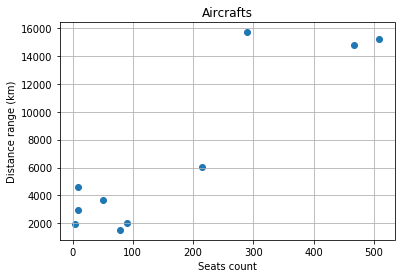

In [2]:
X=np.array([(4,1940),(9,2960),(9,4630),(78,1528),(90,2040),(50,3700),(467,14815),(509,15200),(290,15700),(215,6045)])

x1 = np.array(X[:,0])
x2 = np.array(X[:,1])

fig, ax = plt.subplots()
ax.scatter(x1,x2)
ax.set(xlabel='Seats count', ylabel='Distance range (km)',
       title='Aircrafts')
ax.grid()
plt.show()

Before we go to the next step, we need to normalize our dataset:

In [3]:
train_data = np.array(X)
max_values = train_data.max(0)

X_norm = np.divide(train_data,max_values)

Now, the data is between 0 and 1:

In [4]:
print(X_norm)

[[0.00785855 0.12356688]
 [0.01768173 0.18853503]
 [0.01768173 0.29490446]
 [0.15324165 0.09732484]
 [0.17681729 0.12993631]
 [0.09823183 0.23566879]
 [0.91748527 0.94363057]
 [1.         0.96815287]
 [0.5697446  1.        ]
 [0.42239686 0.38503185]]


Before we start, we should setup a few variables like the assignation matrix, number of clusters, the error margin and feature space:

In [59]:
data_set=X_norm
groups = 2
space=[[0,1],[0,1]]

error_margin = 0.01
m = 2.0

assignation=np.zeros((len(X),groups))

The assignation matrix if filled with zeros as we don't have any guess for assignation yet. We can also fill it randomly with 1 and 0 for each group. The assignation matrix looks like following:

\begin{equation*}
U=\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
\end{bmatrix}.
\end{equation*}


It's time to generate centroid array randomly:
\begin{equation}
 V=[v_{1},v_{2},\ldots,v_{c}].
\end{equation}

We go through each group and add a random array of the feature space centroid positions:

In [39]:
import random

centers = []

def select_centers():
    global centers
    global groups
    global space
    iter=0
    while iter<groups:
        centers.append((random.uniform(space[0][0],space[0][1]), 
                        random.uniform(space[1][0],space[1][1])))
        iter=iter+1
        
select_centers()

Let's take a look what centroids do we have:

In [40]:
print(centers)

[(0.44738077894945405, 0.00982107378299324), (0.9483649318366374, 0.6811711399595101), (0.48928901115108536, 0.7239810240143956)]


To check what is the distance between the centroids and the elements of data set we use the Euclidean distance:

\begin{equation}
 \rho_{Min}(x_{i},v_{j})=\sqrt{\sum_{i=1}^{d}(x_{i}-v_{j})^{2}}.
\end{equation}

In [41]:
import math

def calculate_distance(x,v):
    return math.sqrt((x[0]-v[0])**2+(x[1]-v[1])**2)

The next step is to calculate the new assignation matrix:

\begin{equation}
 \mu_{ik}^{(t)}=
 \begin{cases}
 1 & \text{if } d(x_{k},v_{i})<d(x_{k},v_{j}),  \text{for each } j\neq i\\
 0 & \text{in other case} \\
 \end{cases}.
\end{equation}

In [42]:
def calculate_u(x, i):
    global centers
    distances = [calculate_distance(x, c_i) for c_i in centers]
    result = np.zeros(len(centers))
    result[np.argmin(distances)] = 1
    return result
    
#     if calculate_distance(x, centers[0]) < calculate_distance(x, centers[1]):
#         return [1,0]
#     else:
#         return [0,1]

The third step is to calculate new centroids based on the new assignation matrix $U$:

\begin{equation}
 v_{i}=\frac{\sum_{k=1}^{M}\mu_{ik}^{(t)}x_{k}}{\sum_{k=1}^{M}\mu_{ik}^{(t)}}.
\end{equation}

The calculation is done in two steps: u_x_vector and u_scalar:

In [43]:
def calculate_new_centers(u):
    global centers
    new_centers=[]
    for c in range(groups):
        u_x_vector=np.zeros(2)
        u_scalar=0.0
        for i in range(len(data_set)):
            u_scalar = u_scalar+(u[i][c]**m)
            u_x_vector=np.add(u_x_vector,np.multiply(u[i][c]**m,data_set[i]))
        new_centers.append(np.divide(u_x_vector,u_scalar))
    centers=new_centers

We are almost done here. The last step before we cluster is to set the rule that allow us to stop the loop.

In [44]:
def calculate_differences(new_assignation):
    global assignation    
    return np.sum(np.abs(np.subtract(assignation,new_assignation)))

It's time to combine all together:

In [45]:
def cluster():
    global assignation    
    global error_margin
    difference_limit_not_achieved=True
    iter=0
    while difference_limit_not_achieved:
        new_assignation=[]
        for i in range(len(data_set)):
            new_assignation.append(calculate_u(data_set[i], iter))
        calculate_new_centers(new_assignation)
        if iter>0:
            error = calculate_differences(new_assignation)
            print('error', error)
            if error < error_margin:
                difference_limit_not_achieved=False
        assignation=new_assignation
        iter=iter+1

Ready to build some new clusters: 

In [46]:
cluster()

error 0.0


The centers are like following:

In [47]:
print(centers)

[array([0.07858546, 0.17832272]), array([0.95874263, 0.95589172]), array([0.49607073, 0.69251592])]


And the assignation matrix looks like:

In [48]:
print(assignation)

[array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.]), array([1., 0., 0.]), array([0., 1., 0.]), array([0., 1., 0.]), array([0., 0., 1.]), array([0., 0., 1.])]


To plot it, we need to develop a short function that adds some colors to our plot:

In [141]:
red = X_norm[np.where(np.array(assignation)[:,0]==1)]
blue = X_norm[np.where(np.array(assignation)[:,1]==1)]
# green = X_norm[np.where(np.array(assignation)[:,2]==1)]

IndexError: too many indices for array

And finally plot the results:

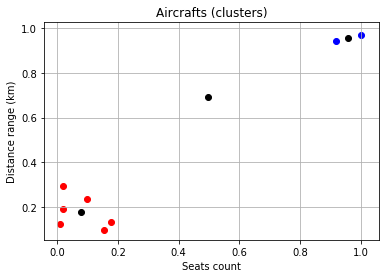

In [50]:
fig, ax = plt.subplots()

ax.scatter(blue[:,0],blue[:,1],c='blue')
ax.scatter(red[:,0],red[:,1],c='red')
ax.scatter(red[:,0],red[:,1],c='red')
ax.scatter(np.array(centers)[:,0],np.array(centers)[:,1],c='black')
ax.set(xlabel='Seats count', ylabel='Distance range (km)',
       title='Aircrafts (clusters)')
ax.grid()
plt.show()

### Exercise 1: Modify the code to work for three groups (max. 15min.)

The obvious part is the variable groups, but the most changes needs to be done here:

In [ ]:
def calculate_u_three(x, i):
    # your code goes here:
    pass

Goals:
1. Modify the calculate_u code.
2. Modify the parameters.
3. Execute the clustering.
4. Plot the results.

## Fuzzy k-means

The fuzzy implementation of k-means is a bit more complex and we need to modify the calculate_u function to be complient with the equation:

\begin{equation}
 \mu_{ik}=(\sum_{j=1}^{c}(\frac{d(x_{k},v_{i})}{d(_{k},v_{j})})^{\frac{2}{m-1}})^{-1}
\end{equation}

In [51]:
def calculate_u(x,i):
    global centers
    if i == 0:
        sum=1.0+(calculate_distance(x, centers[0])/calculate_distance(x, centers[1]))**2
    else:
        sum=1.0+(calculate_distance(x, centers[1])/calculate_distance(x, centers[0]))**2
    return sum**-1

In [60]:
assignation=np.zeros((len(X),groups))
select_centers()

In [61]:
def cluster():
    global assignation    
    global error_margin    
    global groups
    difference_limit_not_achieved=True
    iter=0
    while difference_limit_not_achieved:
        new_assignation=[]
        for i in range(len(data_set)):
            new_assignation_vector=[]
            for k in range(groups):
                new_assignation_vector.append(calculate_u(data_set[i],k))
            new_assignation.append(new_assignation_vector)
        calculate_new_centers(new_assignation)

        if iter>0:
            if calculate_differences(new_assignation) < error_margin:
                difference_limit_not_achieved=False
        assignation=new_assignation
        iter=iter+1

In [62]:
cluster()

In [63]:
print(centers)

[array([0.11241579, 0.19896568]), array([0.83358322, 0.96019472])]


In [64]:
print(assignation)

[[0.9881163699691508, 0.011883630030849185], [0.9928487369257023, 0.007151263074297677], [0.9838624683551898, 0.016137531644810212], [0.9901610803781432, 0.009838919621856831], [0.9921100000332344, 0.007889999966765515], [0.9985493112093143, 0.0014506887906857234], [0.0060436911293874395, 0.9939563088706126], [0.019723698195214866, 0.9802763018047852], [0.07722271126028615, 0.9227772887397139], [0.792727553072923, 0.2072724469270771]]


In [65]:
red = X_norm[np.where(np.array(assignation)[:,0]>0.5)]
blue = X_norm[np.where(np.array(assignation)[:,1]>0.5)]

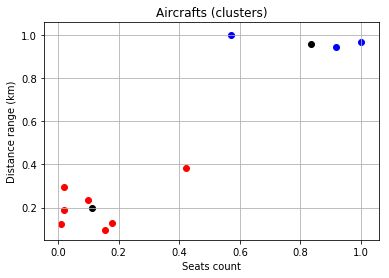

In [66]:
fig, ax = plt.subplots()

ax.scatter(blue[:,0],blue[:,1],c='blue')
ax.scatter(red[:,0],red[:,1],c='red')
ax.scatter(np.array(centers)[:,0],np.array(centers)[:,1],c='black')
ax.set(xlabel='Seats count', ylabel='Distance range (km)',
       title='Aircrafts (clusters)')
ax.grid()
plt.show()

### Homework: Implement possibilistic k-means

Goal:
1. Implement the mahalanobis_distance function.
2. Implement the calculate_eta function.
3. Implement the calculate_u.

Hint: the assignation matrix should not be set to zeros at the beginning.

**Deadline:** 4.04.2018


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis

In [2]:
error_margin = 1e-3

In [3]:
x = np.array([
    [1,0],
    [1,1],
    [2,0],
    [1,2]])
u = np.array([[0.1,0.7,0.3],[0.6,0.2,0.4],[0.7,0.9,0.2],[0.4,0.2,0.6]])
print(x, x.shape)
print(u, u.shape)

[[1 0]
 [1 1]
 [2 0]
 [1 2]] (4, 2)
[[0.1 0.7 0.3]
 [0.6 0.2 0.4]
 [0.7 0.9 0.2]
 [0.4 0.2 0.6]] (4, 3)


In [4]:
c = (np.matmul(u.T, x).T / np.sum(u, 0)).T
v = c
v

array([[1.38888889, 0.77777778],
       [1.45      , 0.3       ],
       [1.13333333, 1.06666667]])

In [5]:
# u = np.random.uniform(size=[4, 3])
u

array([[0.1, 0.7, 0.3],
       [0.6, 0.2, 0.4],
       [0.7, 0.9, 0.2],
       [0.4, 0.2, 0.6]])


The third step is to calculate new centroids based on the new assignation matrix $U$:

\begin{equation}
 v_{i}=\frac{\sum_{k=1}^{M}\mu_{ik}^{(t)}x_{k}}{\sum_{k=1}^{M}\mu_{ik}^{(t)}}.
\end{equation}

The calculation is done in two steps: u_x_vector and u_scalar:

\begin{equation}
    u_ik = (1 + (frac{D_{ikA}, n_i})^{frac{2,m-1})^{-1}}
\end{equation}

In [6]:
def mahalanobis_distance_2(u, v, VI):
    return np.matmul(np.matmul((u - v).T, VI), u - v)

def mahalanobis_distance(u, v, VI):
    return np.sqrt(mahalanobis_distance_2(u, v, VI))

In [7]:
def calculate_eta(u, D2, m):
    u_m = np.power(u, m)
    return np.sum(u_m * D2, axis=0) / np.sum(u_m, axis=0)

In [8]:
def calculate_D2(x, v, A):
    D2 = np.zeros([v.shape[0], x.shape[0]])
    for k, x_k in enumerate(x):
        for i, v_i in enumerate(v):
            D2[i,k] = mahalanobis_distance_2(x_k, v_i, A)
    return D2.T

In [9]:
def calculate_u(u, x, v, m):
#     m = v.shape[0]
#     A = np.linalg.inv(np.cov(x.T))
    A = np.eye(x.shape[1])
    D2 = calculate_D2(x, v, A)
    eta = calculate_eta(u, D2, m)
    eta2 = np.power(eta, 2)
    return np.power(1 + np.power(D2 / eta2, 1 / (m - 1)), -1)

In [10]:
u1 = calculate_u(u, x, v, 2)
u1

array([[0.46228211, 0.4025625 , 0.34143546],
       [0.76417598, 0.22155234, 0.96423412],
       [0.39919935, 0.33428423, 0.24079765],
       [0.28324498, 0.05991352, 0.40262496]])

In [11]:
calculate_new_centers(u1, x, 2)

NameError: name 'calculate_new_centers' is not defined

In [12]:
u1m = np.power(u1, 2)
u1m

array([[0.21370475, 0.16205656, 0.11657817],
       [0.58396492, 0.04908544, 0.92974744],
       [0.15936012, 0.11174595, 0.05798351],
       [0.08022772, 0.00358963, 0.16210686]])

In [13]:
np.sum(u1m[:,2] * x[:,1]) / np.sum(u1m[:,2])

0.9901653031015323

In [14]:
def calculate_new_centers(u, x, m):
    um = np.power(u, m)
    return (np.matmul(um.T, x).T / np.sum(um, axis=0)).T

def calculate_differences(assignation, new_assignation):
    return np.sum(np.abs(np.subtract(assignation, new_assignation)))

def probabilistic_k_means(x, clusters=3, m=2):
#     centers = np.random.uniform(size=[clusters, x.shape[1]])
    assignation = np.random.uniform(size=[x.shape[0], clusters])
    centers = calculate_new_centers(assignation, x, m)
    
    print('u', assignation.shape)
    print('v', centers.shape)
    
    error = error_margin + 1.0
    loops = 0
    while error >= error_margin and loops == 0:
        new_assignation = calculate_u(assignation, x, centers, m)
        error = calculate_differences(assignation, new_assignation)
        centers = calculate_new_centers(new_assignation, x, m)
        assignation=new_assignation
        loops += 1
    print(loops)
    return centers, assignation

In [15]:
x

array([[1, 0],
       [1, 1],
       [2, 0],
       [1, 2]])

In [16]:
u

array([[0.1, 0.7, 0.3],
       [0.6, 0.2, 0.4],
       [0.7, 0.9, 0.2],
       [0.4, 0.2, 0.6]])

In [17]:
v1 = calculate_new_centers(u, x, 2)
u2 = calculate_u(u, x, v1, 2)
u2

array([[0.4775168 , 0.29063586, 0.20414603],
       [0.6434946 , 0.10908169, 0.78505502],
       [0.46345334, 0.44740558, 0.14793413],
       [0.23502992, 0.03477194, 0.52791814]])

In [18]:
v1

array([[1.48039216, 0.66666667],
       [1.58695652, 0.08695652],
       [1.06153846, 1.35384615]])

In [19]:
A = np.linalg.inv(np.cov(x.T))
A = np.eye(2)
D2 = calculate_D2(x, v1, A)
D2

array([[0.67522107, 0.3520794 , 1.83668639],
       [0.34188774, 1.17816635, 0.12899408],
       [0.71443676, 0.17816635, 2.71360947],
       [2.0085544 , 4.00425331, 0.42130178]])

In [20]:
np.sqrt(D2)

array([[0.82171836, 0.59336279, 1.35524403],
       [0.58471167, 1.08543372, 0.35915746],
       [0.84524361, 0.42209756, 1.6473037 ],
       [1.41723477, 2.00106304, 0.64907763]])

In [21]:
eta = calculate_eta(u, D2, 2)
eta

array([0.78556324, 0.37980466, 0.68639053])

In [22]:
u_m = np.power(u, 2)
u_m

array([[0.01, 0.49, 0.09],
       [0.36, 0.04, 0.16],
       [0.49, 0.81, 0.04],
       [0.16, 0.04, 0.36]])

In [23]:
D2

array([[0.67522107, 0.3520794 , 1.83668639],
       [0.34188774, 1.17816635, 0.12899408],
       [0.71443676, 0.17816635, 2.71360947],
       [2.0085544 , 4.00425331, 0.42130178]])

In [24]:
u_m * D2

array([[0.00675221, 0.1725189 , 0.16530178],
       [0.12307958, 0.04712665, 0.02063905],
       [0.35007401, 0.14431474, 0.10854438],
       [0.3213687 , 0.16017013, 0.15166864]])

In [25]:
np.sum(u_m * D2, axis=0) / np.sum(u_m, axis=0)

array([0.78556324, 0.37980466, 0.68639053])

In [26]:
np.sum(u_m[:,0])

1.02

In [27]:
np.sum(u_m[:,0] * D2[:, 0]) / np.sum(u_m[:, 0])

0.7855632449058054

In [53]:
x_norm = x / np.max(x, axis=0)
centers, assignation = probabilistic_k_means(x, 3, m=30)

print(centers)
print(assignation)

u (4, 3)
v (3, 2)
1
[[1.87815132e+00 8.76663271e-02]
 [1.00000000e+00 8.74101525e-15]
 [1.10892922e+00 8.07260456e-01]]
[[0.46879895 0.5        0.47661705]
 [0.46318052 0.1673107  0.49486965]
 [0.5132849  0.1673107  0.46772806]
 [0.45504428 0.16075634 0.46756625]]


In [54]:
a = np.argmax(assignation, axis=1)
a

array([1, 2, 0, 2])

In [55]:
x

array([[1, 0],
       [1, 1],
       [2, 0],
       [1, 2]])

In [56]:
sets = [x[np.where(a == i)] for i in range(len(centers))]

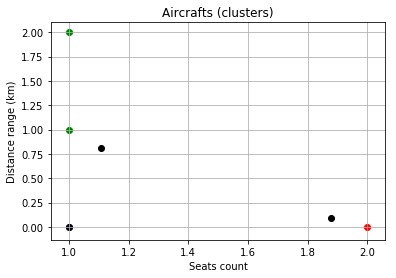

In [57]:
a = np.argmax(assignation, axis=1)

sets = [x[np.where(a == i)] for i in range(len(centers))]
colors = ['red', 'blue', 'green', 'yellow']

# red = X_norm[np.where(np.array(assignation)[:,0]>0.5)]
# blue = X_norm[np.where(np.array(assignation)[:,1]>0.5)]

fig, ax = plt.subplots()

for points, color in zip(sets, colors):
    ax.scatter(points[:,0],points[:,1],c=color)

# ax.scatter(blue[:,0],blue[:,1],c='blue')
# ax.scatter(red[:,0],red[:,1],c='red')
ax.scatter(np.array(centers)[:,0],np.array(centers)[:,1],c='black')
ax.set(xlabel='Seats count', ylabel='Distance range (km)',
       title='Aircrafts (clusters)')
ax.grid()
plt.show()

In [150]:
calculate_eta(u, D2, 1)

array([2.62653326, 0.76260526, 1.16920908])

In [151]:
calculate_u(u, x, v)

array([[0.88399142, 0.2110944 , 0.15308433],
       [0.77312898, 1.        , 0.26552148],
       [0.88399142, 0.15910334, 0.13917202],
       [0.64889293, 0.2110944 , 1.        ]])

In [152]:
x

array([[1, 0],
       [1, 1],
       [2, 0],
       [1, 2]])

In [153]:
v

array([[1.5, 0. ],
       [1. , 1. ],
       [1. , 2. ]])

In [113]:
D2 = calculate_D2(x, v, np.eye(2))
D2

array([[0.25, 1.  , 4.  ],
       [1.25, 0.  , 1.  ],
       [0.25, 2.  , 5.  ],
       [4.25, 1.  , 0.  ]])

In [145]:
q = np.random.uniform(size=[4, 3])
q

array([[0.41404769, 0.20369902, 0.0726578 ],
       [0.14834155, 0.90115109, 0.62986816],
       [0.07516675, 0.46883972, 0.23247114],
       [0.84192144, 0.24737563, 0.84642515]])

In [147]:
def calculate_distance(x, c_i):
    return np.sqrt(np.sum(np.power(x - v, 2), axis=0))

def calculate_u(centers, x):
    distances = [calculate_distance(x, c_i) for c_i in centers]
    result = np.zeros(len(centers))
    result[np.argmin(distances)] = 1
    return result

def calculate_new_centers(u, x):
    return (np.matmul(u.T, x).T / np.sum(u, axis=0)).T

def calculate_differences(assignation, new_assignation):
    return np.sum(np.abs(np.subtract(assignation, new_assignation)))

def probabilistic_k_means(x, clusters=2):
    centers = np.random.uniform([clusters, x.shape[1]])
    assignation = np.random.uniform([x.shape[0], clusters])
    
    error = error_margin + 1.0
    while error >= error_margin:
        new_assignation = calculate_u(centers, x)
        error = calculate_differences(assignation, new_assignation)
        centers = calculate_new_centers(new_assignation, x)
        assignation=new_assignation
    
    return assignation

## Density-based clustering

In density-based clustering the approach is different compared to distributed clustering. We need to implement all functions from scratch. DBScan is an example of a density-based clustering method. The goal is to find all element where the neighborhood is defined as:
\begin{equation}
    N_{\epsilon}:{q|d(p,q)\leq\epsilon},
\end{equation}
where $p$ and $q$ are two elements of the training data set and $\epsilon$ is the neighborhood distance.

Let's setup the variables as in previous examples. The are three new ones like distance_matrix, max_distance and number_of_cluster. The first one is clear, the second is a parameter that can be changed, depending on that how many neighborhood elements we would like to concider. The last variable is about the number of clusters that are calculated during clustering. It's not the exact number of clusters, but allow us count the clusters during clustering.

In [99]:
data_set = X_norm
assignation = np.zeros(len(data_set))
distance_matrix = np.zeros((len(data_set), len(data_set)))
max_distance = 0.2
number_of_cluster = 0

To calculate the distance matrix we use the calculate_distance that we used previously:

In [113]:
def calculate_distance_matrix():
    global distance_matrix
    for i in range(len(data_set)):
        for j in range(len(data_set)):
            distance_matrix[i, j] = calculate_distance(data_set[i], data_set[j])

calculate_distance_matrix()

In [123]:
distance_matrix

array([[0.        , 0.06570659, 0.17161894, 0.1477325 , 0.16907876,
        0.14399364, 1.22471435, 1.30294672, 1.04108163, 0.49010809],
       [0.06570659, 0.        , 0.10636943, 0.16338847, 0.16958165,
        0.0933269 , 1.17465556, 1.25409456, 0.9814524 , 0.4498948 ],
       [0.17161894, 0.10636943, 0.        , 0.2396126 , 0.22921304,
        0.09998591, 1.10927543, 1.19088732, 0.89550719, 0.41462909],
       [0.1477325 , 0.16338847, 0.2396126 , 0.        , 0.04024076,
        0.14887958, 1.14030772, 1.21463622, 0.99413135, 0.3939795 ],
       [0.16907876, 0.16958165, 0.22921304, 0.04024076, 0.        ,
        0.1317385 , 1.10031242, 1.17483479, 0.95467413, 0.3540947 ],
       [0.14399364, 0.0933269 , 0.09998591, 0.14887958, 0.1317385 ,
        0.        , 1.08276779, 1.16177397, 0.8980682 , 0.35692056],
       [1.22471435, 1.17465556, 1.10927543, 1.14030772, 1.10031242,
        1.08276779, 0.        , 0.0860815 , 0.35227984, 0.74642151],
       [1.30294672, 1.25409456, 1.1908873

The next step is to get closest elements in the feature space:

In [124]:
import operator

def get_closest_elements(element_id):
    global distance_matrix
    element_distances = distance_matrix[element_id]
    element_keys = range(len(element_distances))
    element_dict = {element_keys[i]: element_distances[i] for i in range(len(element_distances))}
    return sorted(element_dict.items(), key=operator.itemgetter(1))

Extract only elements within the distance area.

In [125]:
def elements_in_area(distance_vector):
    global max_distance
    for dist_id, distance in distance_vector:
        if distance < max_distance:
            distance_vector.pop(dist_id)
    return distance_vector

And filter the points that we have already visited.

In [126]:
def filter_visited(distances_vector):
    iter=0
    for dist_id, distance in distances_vector:
        if assignation[dist_id] > 0:
            distances_vector.pop(iter)
        iter=iter+1
    return distances_vector

The last step before cluster function is to define funtions that mark the elements in our data set that are known to be a noise or were already visited by our method.

In [127]:
def is_not_visited(element_id):
    global assignation
    if assignation[element_id] > 0:
        return False
    return True

def set_visited(element_id):
    global assignation
    assignation[element_id] = number_of_cluster

def set_as_noise(element_id):
    global assignation
    assignation[element_id] = -1

Combine it all together:

In [128]:
def cluster():
    global number_of_cluster
    calculate_distance_matrix()
    for i in range(len(data_set)):
        if is_not_visited(i):
            number_of_cluster = number_of_cluster + 1
            close_elements = filter_visited(get_closest_elements(i))
            distance_iter = 0
            for dist_id, distance in close_elements:
                if distance < max_distance:
                    distance_iter = distance_iter + 1
                    set_visited(dist_id)
            if distance_iter == 1 :
                set_as_noise(i)

Ready to cluster:

In [129]:
cluster()

The number of cluster is:

In [130]:
print("Number of clusters: "+ str(len(np.unique(assignation))))

Number of clusters: 3


We can see it here as well:

In [131]:
print(assignation)

[ 1.  1.  1.  1.  1.  1.  2.  2. -1. -1.]


### Exercise: Plot the feature space with all element marked with differnet color, depending on the cluster that it's assigned

Use the code below to plot the results. You can play with the max_distance variable to get more or less groups.

In [137]:
# change the bel
def get_colours(color_id):
    global assignation
    global blue
    global red
    colors = ['red','blue','green','orange','black','yellow']
    red = X_norm[np.where(np.array(assignation)[:,0]>0.5)]
    blue = X_norm[np.where(np.array(assignation)[:,1]>0.5)]
    return []
#     pass

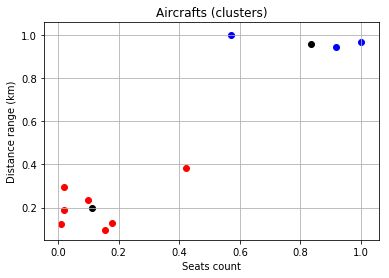

In [138]:
fig, ax = plt.subplots()

# your code or modifications comes here:
ax.scatter(blue[:,0],blue[:,1],c='blue')
ax.scatter(red[:,0],red[:,1],c='red')
ax.scatter(np.array(centers)[:,0],np.array(centers)[:,1],c='black')
# ends here
ax.set(xlabel='Seats count', ylabel='Distance range (km)',
       title='Aircrafts (clusters)')
ax.grid()
plt.show()